In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
IMG_SIZE = 64
NUM_CLASSES = 2  # 0 is background, 1 is defect (bin.)
BASE_DIR = "."
TRAINVAL_FILE = "trainval.txt"
EPOCHS = 50
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "dl_exp_1.pth"

In [3]:
class GradientDefectDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()


        self.images, self.masks = [], []


        for line in lines:
            img_path_rel, ann_path_rel = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_test.jpg"))
            ann_path_full = os.path.join(base_path, ann_path_rel)

            img = Image.open(img_path_full).convert("RGB")
            orig_size = img.size
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            img_np = np.array(img, dtype=np.float32) / 255.0

            gray = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
            grad = np.sqrt(grad_x**2 + grad_y**2)
            grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
            grad = np.stack([grad]*3, axis=2)
            self.images.append(grad.astype(np.float32))

            mask = np.zeros((img_size, img_size), dtype=np.int64)
            scale_x, scale_y = img_size / orig_size[0], img_size / orig_size[1]

            with open(ann_path_full, "r") as f_ann:
                for l in f_ann:
                    parts = l.strip().split()
                    if len(parts) < 5:
                        continue
                    x1, y1, x2, y2, class_id = map(int, parts)
                    if class_id == 0:
                        continue
                    nx1, ny1 = max(0, int(x1 * scale_x)), max(0, int(y1 * scale_y))
                    nx2, ny2 = min(img_size - 1, int(x2 * scale_x)), min(img_size - 1, int(y2 * scale_y))
                    if ny1 < ny2 and nx1 < nx2:
                        mask[ny1:ny2, nx1:nx2] = 1
            self.masks.append(mask)


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.long)
        return img, mask

In [4]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Encoder Path (4 levels)
        self.enc1 = self.conv_block(3, 64, 0.2)      # 64×64 → 64×64
        self.enc2 = self.conv_block(64, 128, 0.2)    # 64×64 → 32×32
        self.enc3 = self.conv_block(128, 256, 0.3)   # 32×32 → 16×16
        self.enc4 = self.conv_block(256, 512, 0.3)   # 16×16 → 8×8

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024, 0.4)  # 8×8 → 4×4

        # Decoder Path
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1 = self.conv_block(1024, 512, 0.3)  # concat with enc4

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = self.conv_block(512, 256, 0.3)   # concat with enc3

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = self.conv_block(256, 128, 0.2)   # concat with enc2

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = self.conv_block(128, 64, 0.2)    # concat with enc1

        # Final output
        self.out_conv = nn.Conv2d(64, num_classes, 1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_c, out_c, drop):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout2d(drop),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        u1 = self.up1(b)
        u1 = torch.cat([u1, c4], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        u2 = torch.cat([u2, c3], dim=1)
        d2 = self.dec2(u2)

        u3 = self.up3(d2)
        u3 = torch.cat([u3, c2], dim=1)
        d3 = self.dec3(u3)

        u4 = self.up4(d3)
        u4 = torch.cat([u4, c1], dim=1)
        d4 = self.dec4(u4)

        return self.out_conv(d4)

In [5]:
def pixel_accuracy(preds, masks):
    return (preds == masks).sum().item() / masks.numel()

def display_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")


    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Pixel Accuracy")


    plt.show()


def display_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.imshow(image.transpose(1, 2, 0))
    plt.title("Input Image")


    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")


    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")


    plt.show()

Epoch [1/50] Train Loss: 0.2616, Train Acc: 0.9566 | Val Loss: 0.2072, Val Acc: 0.9685


Epoch [2/50] Train Loss: 0.1253, Train Acc: 0.9758 | Val Loss: 0.1123, Val Acc: 0.9752


Epoch [3/50] Train Loss: 0.1038, Train Acc: 0.9760 | Val Loss: 0.0997, Val Acc: 0.9752


Epoch [4/50] Train Loss: 0.0925, Train Acc: 0.9762 | Val Loss: 0.0857, Val Acc: 0.9758


Epoch [5/50] Train Loss: 0.0845, Train Acc: 0.9768 | Val Loss: 0.0778, Val Acc: 0.9777


Epoch [6/50] Train Loss: 0.0794, Train Acc: 0.9777 | Val Loss: 0.0728, Val Acc: 0.9794


Epoch [7/50] Train Loss: 0.0756, Train Acc: 0.9783 | Val Loss: 0.0727, Val Acc: 0.9797


Epoch [8/50] Train Loss: 0.0732, Train Acc: 0.9787 | Val Loss: 0.0679, Val Acc: 0.9801


Epoch [9/50] Train Loss: 0.0719, Train Acc: 0.9789 | Val Loss: 0.0654, Val Acc: 0.9803


Epoch [10/50] Train Loss: 0.0692, Train Acc: 0.9793 | Val Loss: 0.0665, Val Acc: 0.9797


Epoch [11/50] Train Loss: 0.0673, Train Acc: 0.9796 | Val Loss: 0.0642, Val Acc: 0.9802


Epoch [12/50] Train Loss: 0.0658, Train Acc: 0.9800 | Val Loss: 0.0627, Val Acc: 0.9808


Epoch [13/50] Train Loss: 0.0642, Train Acc: 0.9804 | Val Loss: 0.0605, Val Acc: 0.9813


Epoch [14/50] Train Loss: 0.0619, Train Acc: 0.9806 | Val Loss: 0.0581, Val Acc: 0.9815


Epoch [15/50] Train Loss: 0.0597, Train Acc: 0.9812 | Val Loss: 0.0596, Val Acc: 0.9814


Epoch [16/50] Train Loss: 0.0581, Train Acc: 0.9816 | Val Loss: 0.0552, Val Acc: 0.9824


Epoch [17/50] Train Loss: 0.0565, Train Acc: 0.9819 | Val Loss: 0.0532, Val Acc: 0.9828


Epoch [18/50] Train Loss: 0.0551, Train Acc: 0.9822 | Val Loss: 0.0557, Val Acc: 0.9821


Epoch [19/50] Train Loss: 0.0542, Train Acc: 0.9826 | Val Loss: 0.0539, Val Acc: 0.9826


Epoch [20/50] Train Loss: 0.0518, Train Acc: 0.9832 | Val Loss: 0.0503, Val Acc: 0.9833


Epoch [21/50] Train Loss: 0.0512, Train Acc: 0.9833 | Val Loss: 0.0505, Val Acc: 0.9836


Epoch [22/50] Train Loss: 0.0490, Train Acc: 0.9839 | Val Loss: 0.0493, Val Acc: 0.9839


Epoch [23/50] Train Loss: 0.0479, Train Acc: 0.9842 | Val Loss: 0.0476, Val Acc: 0.9844


Epoch [24/50] Train Loss: 0.0472, Train Acc: 0.9843 | Val Loss: 0.0474, Val Acc: 0.9843


Epoch [25/50] Train Loss: 0.0463, Train Acc: 0.9846 | Val Loss: 0.0473, Val Acc: 0.9843


Epoch [26/50] Train Loss: 0.0446, Train Acc: 0.9851 | Val Loss: 0.0457, Val Acc: 0.9849


Epoch [27/50] Train Loss: 0.0438, Train Acc: 0.9853 | Val Loss: 0.0467, Val Acc: 0.9848


Epoch [28/50] Train Loss: 0.0428, Train Acc: 0.9857 | Val Loss: 0.0462, Val Acc: 0.9841


Epoch [29/50] Train Loss: 0.0417, Train Acc: 0.9860 | Val Loss: 0.0453, Val Acc: 0.9851


Epoch [30/50] Train Loss: 0.0410, Train Acc: 0.9861 | Val Loss: 0.0446, Val Acc: 0.9854


Epoch [31/50] Train Loss: 0.0402, Train Acc: 0.9864 | Val Loss: 0.0450, Val Acc: 0.9852


Epoch [32/50] Train Loss: 0.0395, Train Acc: 0.9866 | Val Loss: 0.0443, Val Acc: 0.9858


Epoch [33/50] Train Loss: 0.0385, Train Acc: 0.9869 | Val Loss: 0.0422, Val Acc: 0.9855


Epoch [34/50] Train Loss: 0.0377, Train Acc: 0.9870 | Val Loss: 0.0435, Val Acc: 0.9858


Epoch [35/50] Train Loss: 0.0372, Train Acc: 0.9872 | Val Loss: 0.0438, Val Acc: 0.9860


Epoch [36/50] Train Loss: 0.0367, Train Acc: 0.9873 | Val Loss: 0.0434, Val Acc: 0.9856


Epoch [37/50] Train Loss: 0.0356, Train Acc: 0.9876 | Val Loss: 0.0444, Val Acc: 0.9851


Epoch [38/50] Train Loss: 0.0352, Train Acc: 0.9877 | Val Loss: 0.0431, Val Acc: 0.9859


Epoch [39/50] Train Loss: 0.0345, Train Acc: 0.9880 | Val Loss: 0.0424, Val Acc: 0.9862


Epoch [40/50] Train Loss: 0.0331, Train Acc: 0.9884 | Val Loss: 0.0428, Val Acc: 0.9865


Epoch [41/50] Train Loss: 0.0323, Train Acc: 0.9886 | Val Loss: 0.0443, Val Acc: 0.9863


Epoch [42/50] Train Loss: 0.0320, Train Acc: 0.9886 | Val Loss: 0.0442, Val Acc: 0.9857


Epoch [43/50] Train Loss: 0.0309, Train Acc: 0.9890 | Val Loss: 0.0426, Val Acc: 0.9860


Epoch [44/50] Train Loss: 0.0312, Train Acc: 0.9889 | Val Loss: 0.0441, Val Acc: 0.9863


Epoch [45/50] Train Loss: 0.0296, Train Acc: 0.9894 | Val Loss: 0.0437, Val Acc: 0.9860


Epoch [46/50] Train Loss: 0.0304, Train Acc: 0.9892 | Val Loss: 0.0424, Val Acc: 0.9859


Epoch [47/50] Train Loss: 0.0286, Train Acc: 0.9896 | Val Loss: 0.0439, Val Acc: 0.9865


Epoch [48/50] Train Loss: 0.0279, Train Acc: 0.9899 | Val Loss: 0.0452, Val Acc: 0.9854


Epoch [49/50] Train Loss: 0.0280, Train Acc: 0.9898 | Val Loss: 0.0461, Val Acc: 0.9863


Epoch [50/50] Train Loss: 0.0277, Train Acc: 0.9900 | Val Loss: 0.0446, Val Acc: 0.9857
Final model saved to dl_exp_1.pth


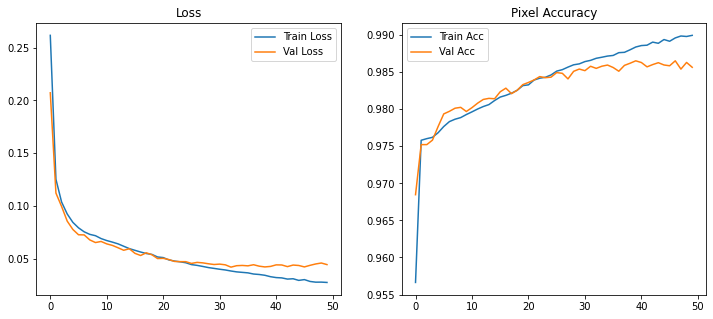

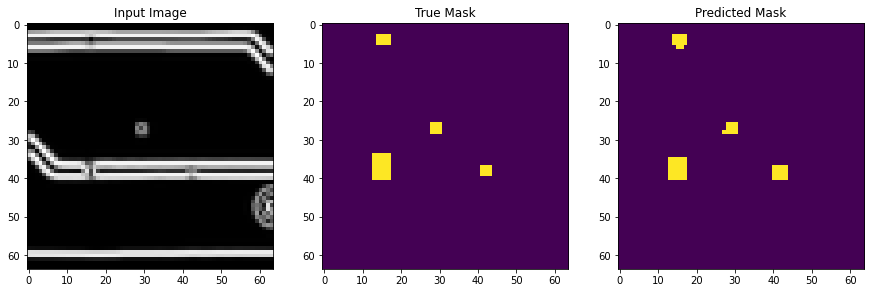

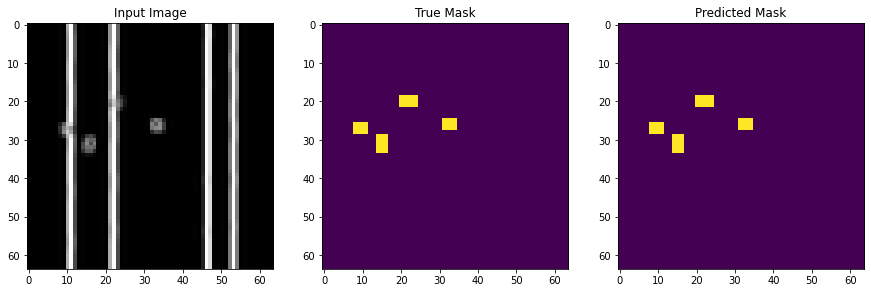

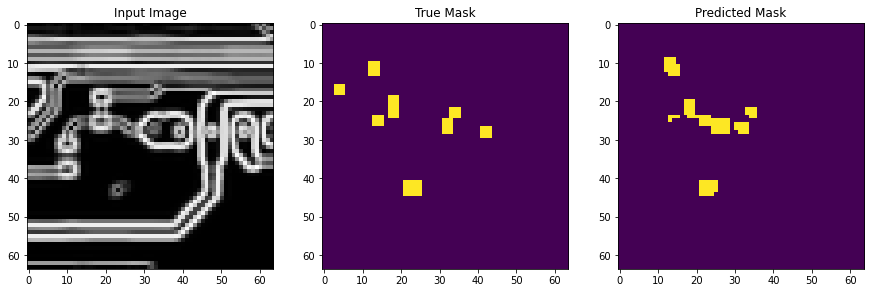

In [6]:
if __name__ == "__main__":
    dataset = GradientDefectDataset(BASE_DIR, TRAINVAL_FILE, IMG_SIZE)
    n_val = int(0.2 * len(dataset))
    n_train = len(dataset) - n_val


    train_set, val_set = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)


    model = UNet(NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs = [], [], [], []


    for epoch in range(EPOCHS):
        model.train()
        running_loss, running_acc = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)


        for imgs, masks in loop:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)


            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)


            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            acc = pixel_accuracy(preds, masks)
            running_acc += acc


            loop.set_postfix(loss=loss.item(), acc=acc)


        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))


        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, masks)


                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_acc += pixel_accuracy(preds, masks)


        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc / len(val_loader))


        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}"
        )

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Final model saved to {MODEL_PATH}")

    display_results(train_losses, val_losses, train_accs, val_accs)
    
    sample_imgs, sample_masks = next(iter(val_loader))
    sample_imgs = sample_imgs.to(DEVICE)
    with torch.no_grad():
        preds = torch.argmax(model(sample_imgs), dim=1).cpu().numpy()


    for i in range(min(3, len(sample_imgs))):
        display_prediction(sample_imgs[i].cpu().numpy(), sample_masks[i].numpy(), preds[i])